# [G-Reaserch] Beginner's Try for simple LGBM

This is a Table Competition to predict future price of cryptocurrencies. A bit similar to the "Optiver" competition a couple of months ago.  
Started from Public Score **0.0077** and improved to **0.4278** so far, experiencing various difficulties...

暗号資産の価格を予想する今回のテーブルコンペ。つい数か月前にあった「Optiver」（株価のボラティリティを予測する）にちょっと似ていて面白そう、と思いトライしてみました。Public Score、**0.0077**からスタートし、四苦八苦しながら、とりあえず**0.7005**まで上げてきました。。。

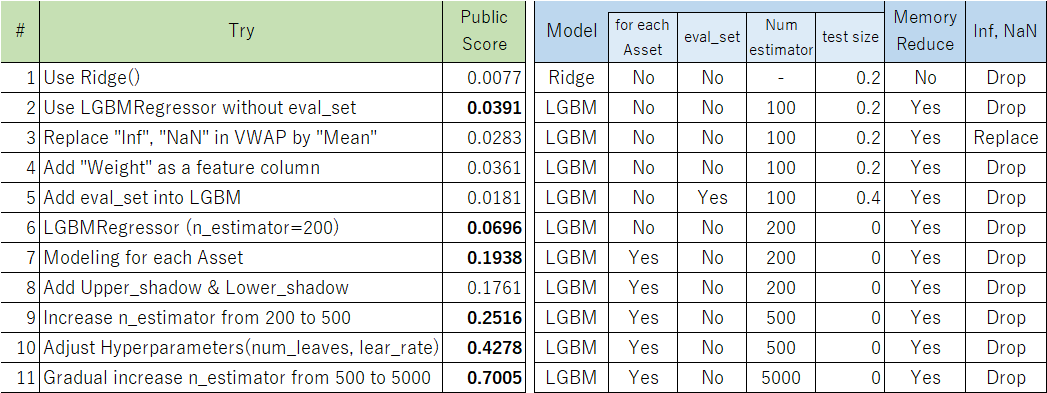

# (1) (2) Build simple model

**(1) Build simple model using Ridge()**  
At first, anyway use the as-is data into the simple model, and let's see how good score I can get.  
Referring to KONRAD BANACHEWICZ's code in below link, tried to feed the training data into Ridge model.  
The result is Public score **0.007**, which is a little bit better than original code since I added VWAP as a feature.  
Well, this seems not so bad as a starting score.

とりあえず、あまり何も考えず、シンプルなモデルでどの程度のスコアが出るか見てみよう。  
KONRAD BANACHEWICZさんのコードを参考に、ModelとしてRidgeを使いTraining Dataを投入してみる。  
結果は、Public Score：**0.007**。投入データとしてVWAPも追加したので参考コード（0.005）に比べて少し良かった。  
最初は、ま、こんなもんでしょ。  
https://www.kaggle.com/konradb/super-simple-baseline

In [ ]:
# model = Ridge()
# model.fit(trn_x[col_subset],trn_y)

**(2) Use LightGBM**  
Next, tried to use LGBMRegressor, simple model to fit with x/y only without eval_set.  
What I was confused here is, I encountered frequent Memory-over error which did not happen in Ridge model.  
Of course, the original training data itself is very huge, and memory-over error makes sense...  
Referring to the below Discussion, introduced "reduce_mem_usage" function.  
The result is, Public score was improved to **0.039**.  Well!, it works so good to simply change from Ridge to LGBM.  
Let's start to see the actual code!

次に、LGBMを使ってみる（eval_setはセットせず、x・yだけ投入してfitするシンプルなモデル）。ここで困ったのが、Ridgeモデルの時は問題なかった「メモリーオーバーエラー」。  
まぁ、元のデータが巨大なので、仕方ないと思いますが。。  
以下のDiscussion（のリンク先）を参考に、Trainingデータの容量を削減する関数（reduce_mem_usage）を追加。  
https://www.kaggle.com/c/g-research-crypto-forecasting/discussion/285719  
結果は、Public Score＝**0.039**。へぇー、LGBMにするだけでこんなにスコア良くなるんだ。

とりあえずこのあたりで、コードをご紹介していきます。

In [ ]:
import gresearch_crypto
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [ ]:
df_train = pd.read_csv('../input/g-research-crypto-forecasting/train.csv')
df_test = pd.read_csv('../input/g-research-crypto-forecasting/example_test.csv')

In [ ]:
df_train.info()

Hmmm.. As mentioned in above (2), Training data is huge. It may be because of unnecessary Float64 of Dtypes. (e.g. "Count" doesn't need to be Float64.) Let's reduce the data memory later.

ふむふむ。上記(2)で書きましたが、Training Dataが巨大なのは、むだにデータタイプがFloat64で保持されていたりするからなんでしょうね (Countとか件数なんだからFloat64である必要性ない）。のちほど、軽くします。

In [ ]:
df_train.describe()

# (3) Try to replace Nan, Inf, -Inf by Mean  
From a look at Training data, I can see NaN, Inf, -inf. They were dropped so far (code [12]), but come up with the idea that it may improved the score if replace them by the other value such as "Mean". Let's try :-)  
The result is, Failed... Public score became worse to **0.028**. OK, I'm convinced that they should be dropped rather than change.

Describeでtrainingデータを概観すると、NaN、Inf、-infが見える。これまで、これらのレコードはDrop（コード[12]）してたけど、平均値に置き換えたりしたら少しはスコア改善するかな？と思い、試してみる。  
が、見事に惨敗。。スコアは**0.028**に低下。なるほど、変に適当な数値に変えるよりも落とせ、ということですね。納得。

In [ ]:
df_train.isnull().sum()

In [ ]:
a1 = df_train["VWAP"].isin([np.inf])
a2 = df_train["VWAP"].isin([-np.inf])
a3 = df_train["VWAP"].isin([np.nan])
print ("inf:", a1.sum(), "  -inf:", a2.sum(), "  nan:", a3.sum())

In [ ]:
df_train[df_train["Target"].isna()].head()

In [ ]:

#df_train["VWAP"]=df_train["VWAP"].replace([np.inf, -np.inf], np.nan)

#vwap_mean = df_train[["Asset_ID", "VWAP"]].groupby("Asset_ID").mean().reset_index()
#vwap_mean.columns = ["Asset_ID", "vwap_mean"]

#df_train = pd.merge(df_train, vwap_mean, on = "Asset_ID", how = "left")
#df_train.loc[(df_train["VWAP"].isnull()), "VWAP"] = df_train["vwap_mean"]
#df_train = df_train.drop("vwap_mean", axis = 1)
#df_train.describe()

# (4) Try to add "Weight" as one of the features  
I can see "asset_details" file as well as Training data. It is small file basically to show which Asset ID is which cryptocurrency, but I'm not sure what the "Weight" shows.. Let's add it to features, and see how Score becomes.  
However, no, the score went slightly down to **0.036**. (Code [11] is just FYI, actually not used)

Trainingデータ以外に、asset_detailsというファイルも用意されている。どのAssetIDが実際には何の暗号通貨かを示したりするSmallなファイルだけど、ここにあるWeightというのが何に使うのかよくわからない。とりあえず特徴量の一つに加えてスコアが良くなるか見てみる。  
。。。ダメですね。Scoreは**0.036**と僅かに悪化しました。（コード[11]はその名残です。。結果的には使ってません。）

In [ ]:
df_asset = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
df_asset

In [ ]:
def feature_adjust(df) :
    feature_cols = ['Asset_ID', 'Close', 'Count', 'High', 'Low', 'Open', 'VWAP','Volume', 'timestamp'] 
                #"Upper_shadow", "Lower_shadow"] #Bull_Bear
    categories = ["Asset_ID", "timestamp"] #Bull_Bear
    
    x = df[feature_cols].copy()
    #df = pd.merge(df, df_asset, on = "Asset_ID", how = "left")
    #df = df.drop("Asset_Name", axis = 1)
    return x

In [ ]:
df_train = df_train[~df_train.isin([np.nan, np.inf, -np.inf]).any(1)].reset_index(drop=True)
#df_train = feature_adjust(df_train)

In [ ]:
df_train

In [ ]:
#feature_cols = ['Asset_ID', 'Close', 'Count', 'High', 'Low', 'Open', 'VWAP','Volume', 'timestamp'] # "Weight"
#categories = ["Asset_ID", "timestamp"]

In [ ]:
def reduce_mem_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    df["Count"] = df["Count"].astype(np.int16)

    end_mem = df.memory_usage().sum() / 1024**2
    
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
     
    return df

df_train = reduce_mem_usage(df_train)

Above [15] is the function to reduce the data memory. Data type Float64 is changed, and then Training data was reduced from 1.8GB to 0.5GB. Data type change works well like this. I see.

上記の[15]が、データメモリーを削減する関数で、Float64のデータタイプを変えることでTrainingデータが1.8GBから0.5GBへと削減されています。データタイプを変えるだけでこんなに違うんだ。へー。

In [ ]:
df_test = reduce_mem_usage(df_test)

In [ ]:
#x_train = df_train[feature_cols].copy()
#y_train = df_train['Target'].copy()

In [ ]:
#train_x = x_train.copy()
#train_y = y_train.copy()
#train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 0.4)

# (5) Try to use "eval_set" in LGBM  
Tried to improve the model in the latter half of code[19], adding "eval_set" to study with (train_x, train_y) and evaluate with (valid_x, valid_y). Then, always Memory-over error happens.  
When make the test size bigger to 0.4 (= make dataset for fitting smaller to 0.6), somehow it worked without error. Let's see the Public score.  
Oh, miserable.. Public score went down to **0.018**. Once sit down and consider again, it may make sense because only 60% of entire training data is used.

コード[19]の後半では、eval_setもつけて(train_x, train_y)で学習、(valid_x, valid_y)で評価して学習モデルを向上させようとしてみた。。。頻繁にメモリーオーバーが発生。test_sizeを0.4と大きめにする（学習に使うデータセットを0.6と小さくする）と、なんとか動いたので、これでスコアを見てみる。。。  
惨敗ですね、スコアは**0.018**へと大きく悪化。そりゃそうか、トレーニングデータの6割しか使ってないんだもんね。

# (6) LGBM (test_size = 0, N_estimators = 200)  
After all, I changed the model back to simple fit(x,y).  
If so, don't need to split the training data for validation, hence no use for train_test_split.  
In the above (5) process, I confirmed that the epoch of training went over 100 without early stopping and arrived at almost 200. Thus increased the n_estimators from the default 100 to 200. Now, let's see.  
The result is... Public score shows **0.069**, much improved. Good! (^o^)/

ということで、modelは単純なfit(x,y)に戻した。そうなると、トレーニングデータの一部をvalidate用に取り分ける必要もないので、train_test_splitも使わず。上記(5)で、学習が100回を超えてもearly stoppingがかからず200回近くまで学習が進んだことは確認できたので、学習回数をデフォルトの100から200に増やす。  
すると、結果は。。。Public Scoreは**0.069**への大きく改善。良しよし。　(^o^)/

In [ ]:
lgb_params = {
    "objective": "regression",
    "n_estimators" : 5000,     # <-- (9) change from 200 to 500
    "num_leaves" : 300,       # <-- (10) Added parameter
    "learning_rate" : 0.09,   # <-- (10) Added parameter
    "random_seed" : 1234}
    
#model = lgb.LGBMRegressor(**lgb_params)
    
#model.fit(train_x, train_y)

#model.fit(
#    train_x, 
#    train_y,
#    eval_set = (valid_x, valid_y),    
#    early_stopping_rounds = 20,
#    verbose = 10,
#    categorical_feature = categories,
#    )



# (7) Modeling for each Asset ID

So far, in the above (1)-(6), I took an easy way to feed the entire Training data into the model at one shot.  
However, the price trend is of course varied for each Asset, thus tried to fit per each Asset.  
The result of Public score is... **0.1938**. I see, only modeling change from "for all data" to "for each asset" can improve the score like this!

上記(1)～(6)では、簡易的にTrainingデータをまとめてモデルに投入していたが、Asset毎に価格傾向も違うので、Asset毎に分けて学習させてみる。  
結果は、**0.1938**へと大きく上昇。へぇー、個別アセット毎のモデルにするだけで、こんなに改善するんだ。

In [ ]:
def get_model (asset_id) :
    
    df = df_train[df_train["Asset_ID"] == asset_id]
    
    x = feature_adjust(df)
    #x = df[feature_cols].copy()
    y = df['Target'].copy()
        
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(x, y)
    
    return model

In [ ]:
asset_ids = list(df_asset["Asset_ID"].unique())
asset_ids.sort()
models = {}

for asset_id in asset_ids :
        
    print(f"Training model for  ID={asset_id}")
    
    model = get_model(asset_id)
    models[asset_id] = model

In [ ]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

#for (test_df, sample_prediction_df) in iter_test:
    
#    test_df = feature_adjust(test_df)
#    test_sub = test_df[feature_cols]
#    sample_prediction_df['Target'] = model.predict(test_sub)
#    env.predict(sample_prediction_df)

In [ ]:
for i, (df_test, df_pred) in enumerate(iter_test) :
    df_test = reduce_mem_usage(df_test)
    
    for j , row in df_test.iterrows():        
        
        model = models[row['Asset_ID']]
        x_test = feature_adjust(row)
        #x_test = x_test.drop(["row_id"])
        y_pred = model.predict(pd.DataFrame([x_test]))[0]
        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
    
    env.predict(df_pred)

# (8) Add "Upper_shadow", "Lower shadow" as features  

So far, I used as-is fields in the existing Training data, but try to create new features.  
From a look at some Web-sites to explain the price of Stock, many sites seem to be explaining Candle Stick (refer to below diagram), with regard to Open , High, Low and Close price.  
First, try to create "Upper shadow", "Lower shadow" using the eixiting these existing 4 prices.  
Let's see how Public Score shows... the result is **0.1761** ...Why? Score have got worse. I'm wondering if simply adding them doesn't work?   

これまでは、Trainingデータにある項目をそのまま特徴量として使ってきたが、これらの項目を使って新しい特徴量を作ってみる。  
株価を開設しているWebサイトを見ると、既存の特徴量である始値・高値・安値・終値に関してローソク足（下図参照）を解説しているサイトが多い。  
まずは、ローソク足の特徴である「上ヒゲ」「下ヒゲ」を作ってみる。  
Public Scoreの結果は。。。**0.1761**。あれ？スコアが悪くなってる。単純に加えただけだとだめなのか？

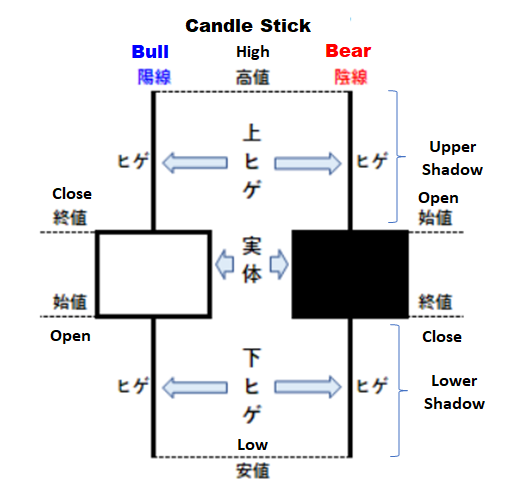

In [ ]:
# FYI, for "Upper_shadow" and "Lower_shadow", following codes were used.
# ご参考まで、上ヒゲ・下ヒゲには以下のコードを使いました。
    
    #df["Upper_shadow"] = df["High"] - np.maximum(df["Open"], df['Close'])
    #df["Lower_shadow"] = np.minimum(df["Open"], df['Close']) - df["Low"]

# (9) Increase n_estimators from 200 to 500

Above (8) was less efficient than expected (rather got worse), thus tried more simple way which is to increase n_estimators from 200 to 500 (In[19]).  
The result is, Public score has got better to **0.2516**. This is the simple method but much more efficient than expected.

上記(8)が思ったほど効果がなかった（むしろ悪化した）ので、シンプルに学習回数を200→500に増やしてみる（In[19]）。  
結果は、Public Scoreが**0.2516**へと上昇。単純だけど思った以上の効果があった。

# (10) Adjust Hyperparameters

Since the above(9) was much more improved than expected, tried to adjust other hyperparameters(num_leaves, learning_rate) as well, refering to the below link.  
The result is, Public score has been much improved to **0.4278**. It is surprising that just a slight parameter adjustment contributes to much improvement like this. (Wait, actually the biggest improvement so far...)  

上記(9)でn_estimatorsを変えるだけで予想以上の改善となったので、他のHyperparameter(num_leavesとlearning_rate)も少し調整してみる。  
調整項目については、以下のリンクを参考にさせていただきました。  
https://www.kaggle.com/swaralipibose/lgdm-model-with-new-features-better-generalization

驚くことに、結果は**0.4278**へと大きく改善。Hyperparameter変えるだけでこんなにスコアが改善するんだ。  
（というか、これまでで一番大きな改善幅なんですけど。。）

# (11) Gradual increasing n_estimator from 500 to 5000

Based on the result of the above (9), I'll attempt to gradually increase n_estimator to see how the score is improved.  
I had assumed the score will get worse due to over-fitting if increased the number too much, however, the more and more n_estimator is increased the higher and higher the score becomes, which is the interesting result.  
(it takes 4-5 hours to see the score result after submission, hence this experiment required 1 week... got tired..)

ここから少し実験し、上記(9)の結果を踏まえ、n_estimatorを徐々に増やしていき、どこまでScoreが伸びるかを試してみる。  
どこかで過学習の影響が出てスコアは悪くなると思ったが、意に反してn_estimatorを増やせば増やすほどスコアは改善し、なかなか面白い結果となった。  
（提出後スコアが出るのに4・5時間かかるので、この実験、一週間ほど掛かりました。。疲れた；；）

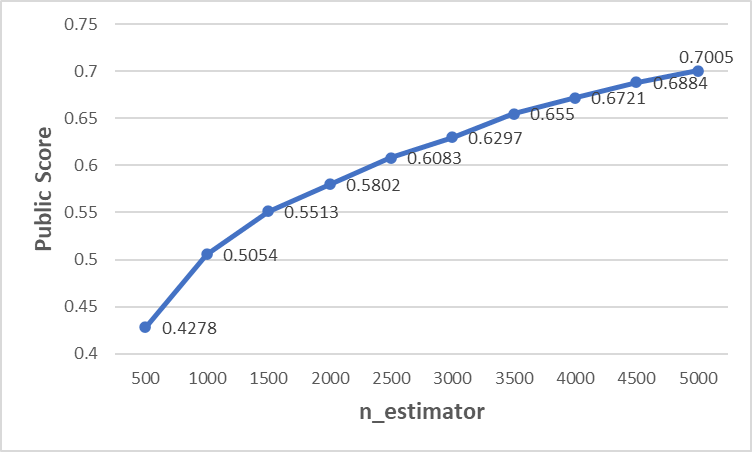